# VMamba

### Data

In [1]:
import torch 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(device)
print(device)

cuda:0


In [2]:
import torch
from torch.utils.data import Dataset
from torch.nn.functional import pad
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, ds, split='train'):
        self.ds = ds[split]
        self.split = split

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image = torch.tensor(np.array(self.ds[idx]['image'].convert("RGB")), dtype=torch.float32).transpose(-3, -1).cuda()
        label = torch.tensor(self.ds[idx]['label'], dtype=torch.long).cuda()
        
        return image, label

def get_padding(image, max_w, max_h):
    h_padding = (max_w - image.shape[-1])
    v_padding = (max_h - image.shape[-2])
    d_padding = (3 - image.shape[-3])
    
    padding = (0, h_padding, 0, v_padding, 0, d_padding)
    
    return padding

def pad_images(data):
        max_w = max([d[0].shape[-1] for d in data]) 
        max_h = max([d[0].shape[-2] for d in data])

        padded_imgs = torch.empty((len(data), 3, max_h, max_w))
        for i, d in enumerate(data):
             padding = get_padding(d[0], max_w, max_h)
             padded = pad(d[0], padding)
             padded_imgs[i] = padded

        return padded_imgs.cuda(), torch.tensor([d[1] for d in data]).cuda()
    
# test_pad = ds['train'][:3]['image']
# print([img.size for img in test_pad])

# print(get_padding(test_pad[0], 500, 500))
# padded = pad_images(test_pad)
# print([img.shape for img in padded])


In [3]:
from datasets import load_dataset
from torch.utils.data import DataLoader

ds = load_dataset("zh-plus/tiny-imagenet")
print(ds.shape)

train_data = ImageDataset(ds, split='train')
val_data = ImageDataset(ds, split='valid')

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=pad_images, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=pad_images, shuffle=True)

/home/bcs/miniconda3/envs/vmamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'train': (100000, 2), 'valid': (10000, 2)}


### Model

In [ ]:
import vmamba as vm
import torch
from torch import nn
import numpy as np

default_model = 'hilbert'
# default_model = 'standard'

models = {
    'standard': vm.vmamba_itty().cuda(),
    'hilbert': vm.vmamba_itty_hilbert().cuda(),
    }
    
print(np.sum([p.numel() for p in models[default_model].parameters()], axis=0))
print(next(models[default_model].parameters()).device)

13252552
cuda:0


In [5]:
import numpy as np

input, label = next(iter(train_loader))
print('in', input.shape)
print(torch.argmax(models[default_model](input), dim=-1))
print(label)

in torch.Size([64, 3, 64, 64])
tensor([126,  21,  21,  21,   5,  21,  37,  21,  21,  21, 115,  96,  21,  21,
         49,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,
         49,  21,  21,   5,   4, 115,  21,  21, 115,   4,  21,   5,   4,  21,
         37, 115,  21,  21,  21,  21,  21,  21,  21,  37, 115,  21,   4,  21,
         49,  21,  21,  21,  21,  21,  21, 157], device='cuda:0')
tensor([ 46,  30,  19, 131,  52, 106, 123,  77,  30, 117, 134,  84, 147,  18,
        133, 178, 147,  62, 166,  55,  22,  44, 181,  44, 159, 160, 189, 137,
         35,  26, 157, 124, 111, 159,  21, 188,  28,   0,  56, 170,  29,  32,
        120, 139, 165, 128, 118,  40, 181,  32,  14, 131, 136,  42,  24, 158,
        104, 149, 186, 148,  11, 185,  10,  28], device='cuda:0')


### Training

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from typing import Dict, Tuple, List
from sklearn.metrics import accuracy_score
from torcheval.metrics.functional import multiclass_accuracy


# Assumes same optimizer and loss for each model
def train_compare(
      n_epochs:int, 
      models:Dict[str, nn.Module], 
      train_loader:DataLoader, 
      val_loader:DataLoader = None, 
      opt:torch.optim.Optimizer = torch.optim.AdamW, 
      loss_fn:nn.Module = nn.CrossEntropyLoss,
      verbose:int = 0,
      accuracy:bool = False,
    ):

    train_losses = [[] for _ in range(len(models))]
    val_losses = [[] for _ in range(len(models))]

    train_acc = [[] for _ in range(len(models))]
    val_acc = [[] for _ in range(len(models))]

    report_freq = max(n_epochs // 10 * verbose, 1)

    tl = iter(train_loader)
    if val_loader is not None: vl = iter(val_loader)

    #initialize
    optimizers = [opt(mod.parameters(), lr=1e-2) for mod in models.values()]
    loss_fn = loss_fn()

    for m in models.keys(): print(f'\t{m}', end="")
    print()
    
    for e in range(n_epochs):
        train_X, train_y = next(tl)
        
        for i, (model, optimizer) in enumerate(zip(models.values(), optimizers)):
          model.train()
          optimizer.zero_grad()
          
          # Make predictions for this batch
          if verbose >= 2: print('forward, ', end="")
          train_out = model(train_X)
          
          
          # Compute the loss and its gradients
          if verbose >= 2: print('back, ', end="")
          loss = loss_fn(train_out, train_y)
          loss.backward()
          
          # Adjust learning weights
          if verbose >= 2: print('step', end="")
          optimizer.step()

          # Append training and validation loss to lists
          train_losses[i].append(loss.item())

          # Obtain training accuracy curve
          if accuracy:
            training_accuracy = multiclass_accuracy(train_out, train_y, k=10)
            train_acc[i].append(float(training_accuracy))

          # Print information out
          if verbose >= 1 and e % report_freq == 0:
            if i < len(models)-1: print(f'{e:03d}:\t', end="") 
            print(f'{loss:.4f}\t', end="")
            print('\t' if i < len(models)-1 else '\n', end="")

          # Get validation losses
          if val_loader is not None and e % (len(train_loader.dataset)//len(val_loader.dataset)) == 0:
            model.eval()
            val_X, val_y = next(vl)
            val_out = model(val_X)
            epoch_val_loss = loss_fn(val_out, val_y)
            val_losses[i].append(epoch_val_loss.item())

            if accuracy:
              val_accuracy = multiclass_accuracy(val_out, val_y, k=10)
              val_acc[i].append(float(val_accuracy))

    if val_loader is None: 
      if accuracy:
        return train_losses, train_acc
      return train_losses
    else:
      if accuracy:
        return train_losses, train_acc, val_losses, val_acc
      return train_losses, val_losses



In [7]:
n_epochs = 100

train_loss, train_accuracy, val_loss, val_accuracy = train_compare(n_epochs, models, train_loader, verbose=1, accuracy=True, val_loader=val_loader)
# print(train_loss)

	standard	hilbert
000:	5.3886		5.3525	
010:	9.1244		8.2882	
020:	7.0323		6.6040	
030:	6.3143		6.1045	
040:	5.9943		5.5425	
050:	5.9015		5.6243	
060:	5.5220		5.4686	
070:	5.4594		5.4039	
080:	5.4271		5.4329	
090:	5.4054		5.3801	


### Plots

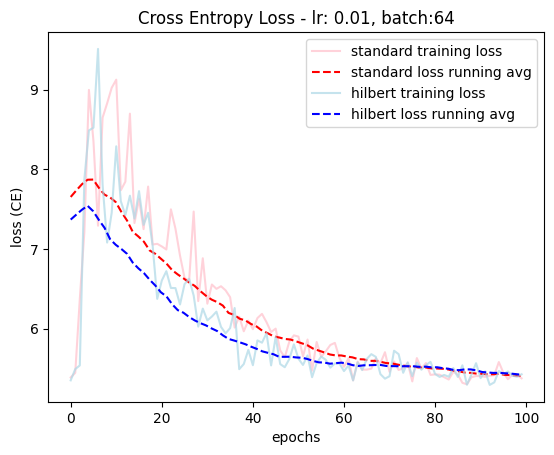

In [ ]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

def moving_average(y, window=10):
    average_y = []
    for ind in range(len(y) - window + 1):
        average_y.append(np.mean(y[ind:ind+window]))

    return np.array(average_y)

current_time = datetime.datetime.now()

t_colors = ['pink', 'lightblue']
avg_colors = ['red', 'blue']
for i, (model_name, model) in enumerate(models.items()):
    
    t_loss = train_loss[i]
    plt.plot(t_loss, label=f'{model_name} training loss', alpha=0.7, color=t_colors[i])

    x = range(n_epochs)
    y = moving_average(t_loss, window=max(n_epochs//5, 1))
    plt.plot(np.linspace(0, n_epochs-1, len(y)), y,"--", color=avg_colors[i], label=f'{model_name} loss running avg')

    plt.title(f'Cross Entropy Loss - lr: {0.01}, batch:{batch_size}')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss (CE)')
    
plt.savefig(f'output/M{model_name}B{batch_size}T{current_time}.png')

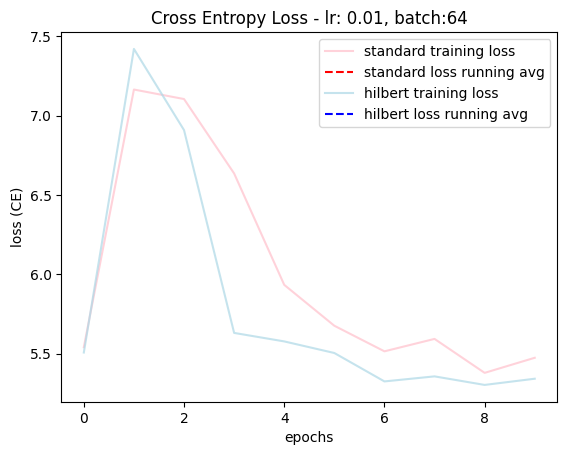

In [ ]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

def moving_average(y, window=10):
    average_y = []
    for ind in range(len(y) - window + 1):
        average_y.append(np.mean(y[ind:ind+window]))

    return np.array(average_y)

current_time = datetime.datetime.now()

t_colors = ['pink', 'lightblue']
avg_colors = ['red', 'blue']
for i, (model_name, model) in enumerate(models.items()):
    
    t_loss = val_loss[i]
    plt.plot(t_loss, label=f'{model_name} training loss', alpha=0.7, color=t_colors[i])

    x = range(n_epochs)
    y = moving_average(t_loss, window=max(n_epochs//5, 1))
    plt.plot(np.linspace(0, n_epochs-1, len(y)), y,"--", color=avg_colors[i], label=f'{model_name} loss running avg')

    plt.title(f'Cross Entropy Loss - lr: {0.01}, batch:{batch_size}')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss (CE)')
    
plt.savefig(f'output/M{model_name}B{batch_size}T{current_time}.png')

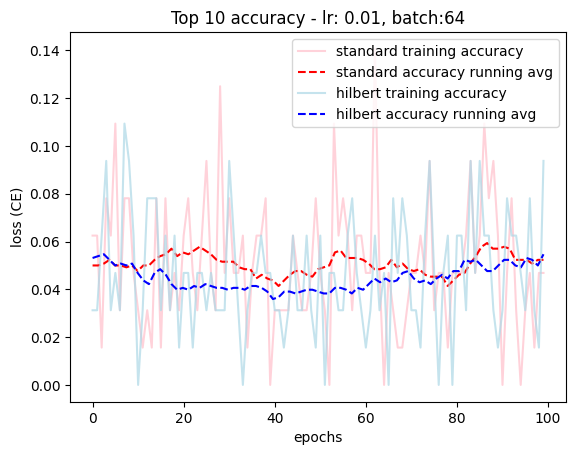

In [ ]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

def moving_average(y, window=10):
    average_y = []
    for ind in range(len(y) - window + 1):
        average_y.append(np.mean(y[ind:ind+window]))

    return np.array(average_y)

current_time = datetime.datetime.now()

t_colors = ['pink', 'lightblue']
avg_colors = ['red', 'blue']
for i, (model_name, model) in enumerate(models.items()):
    
    t_loss = train_accuracy[i]
    plt.plot(t_loss, label=f'{model_name} training accuracy', alpha=0.7, color=t_colors[i])

    x = range(n_epochs)
    y = moving_average(t_loss, window=max(n_epochs//5, 1))
    plt.plot(np.linspace(0, n_epochs-1, len(y)), y,"--", color=avg_colors[i], label=f'{model_name} accuracy running avg')

    plt.title(f'Top 10 accuracy - lr: {0.01}, batch:{batch_size}')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss (CE)')
    
plt.savefig(f'output/M{model_name}B{batch_size}T{current_time}.png')

# Pathing Tests

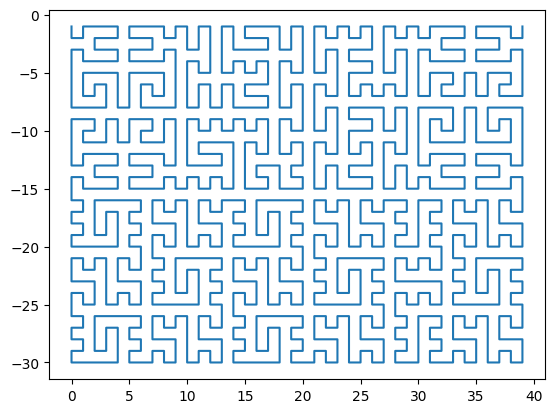

In [ ]:
import spacefill.curvetools as ct
import numpy as np


x_size, y_size = 40, 30
curve_map = ct.generate_map(x_size, -y_size)

import matplotlib.pyplot as plt
px, py = list(zip(*(curve_map[0])))
inds = torch.tensor([(-y-1)*x_size + x for x, y in curve_map[0]], dtype=torch.int64)
plt.plot(px, py)
plt.show()
arr = torch.arange(0,x_size*y_size).reshape(y_size, x_size)
arr_sort = arr.flatten().gather(dim=-1, index=inds).reshape(y_size, x_size)